In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from pathlib import Path
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
# dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-17-12_14_'


In [2]:
def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB

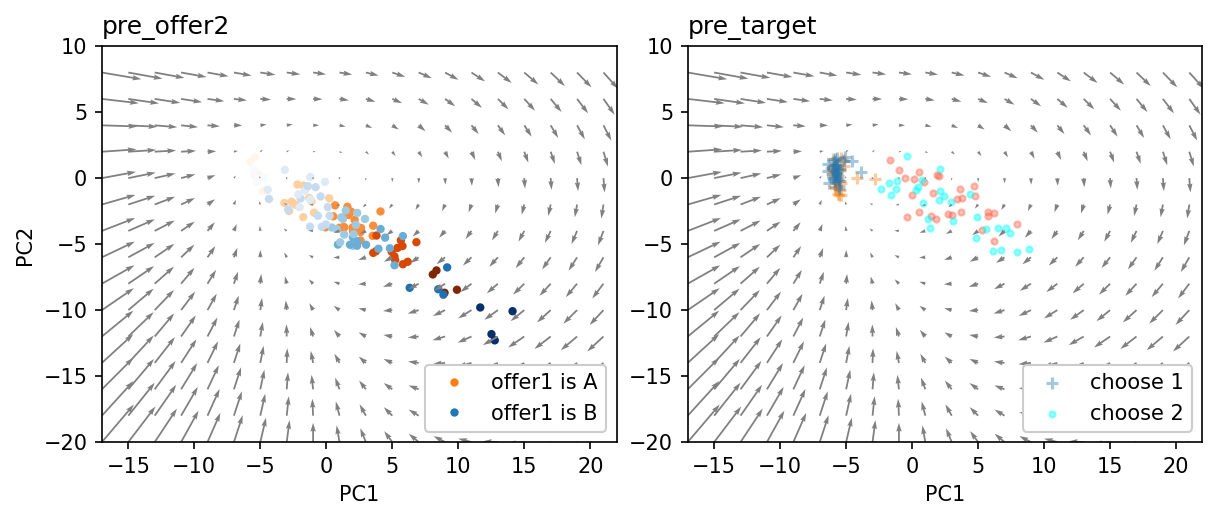

In [3]:
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')


K,T,N = model_state.shape

pcaObj = PCA(n_components=4)
X = model_state[:,50:250,:].reshape((K*200,N))
pcaObj.fit(X)

t0=50
t1=150
t2=250
xx,yy=0,1
fig = plt.figure(figsize=(8,6),dpi=150,constrained_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122,sharex=ax1,sharey=ax1)

xmin, xmax, ymin, ymax = -17,22,-20,10

ax = ax2
points = pcaObj.transform(np.squeeze(model_state[:,t2,:]))
ax2.scatter(points[(choiceAB=='A')&(seqAB=='AB'),xx],points[(choiceAB=='A')&(seqAB=='AB'),yy],marker='+',alpha=0.4,color='tab:orange',label='_Hidden choose 1')
ax2.scatter(points[(choiceAB=='A')&(seqAB=='BA'),xx],points[(choiceAB=='A')&(seqAB=='BA'),yy],marker='.',alpha=0.4,color='tomato',label='_Hidden choose 2')
ax2.scatter(points[(choiceAB=='B')&(seqAB=='BA'),xx],points[(choiceAB=='B')&(seqAB=='BA'),yy],marker='+',alpha=0.4,color='tab:blue',label='choose 1')
ax2.scatter(points[(choiceAB=='B')&(seqAB=='AB'),xx],points[(choiceAB=='B')&(seqAB=='AB'),yy],marker='.',alpha=0.4,color='aqua',label='choose 2')
# ax2.set_xlabel('PC%d'%(xx+1))
ax2.set_xlabel('PC%d'%(xx+1))
# ax2.set_ylabel('PC%d'%(yy+1))

ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
# ax.text(xmin+(xmax-xmin)*0.01,ymin+(ymax-ymin)*0.01,"t=%dms"%(t2*10))
ax.set_title('pre_target',loc='left')
ax.legend(frameon=True,loc='lower right',framealpha=1)


ax = ax1
points = pcaObj.transform(np.squeeze(model_state[:,t1,:]))
sctA = ax1.scatter(points[seqAB=='AB',xx],points[seqAB=='AB',yy],marker='.',
        c = qAs[seqAB=='AB'],cmap='Oranges')
proxyA, = ax.plot([],[],marker='.',color='tab:orange',linestyle='None',label='offer1 is A')
sctB = ax1.scatter(points[seqAB=='BA',xx],points[seqAB=='BA',yy],marker='.',label='offer1 is B',
        c = qBs[seqAB=='BA'],cmap='Blues')
proxyB, = ax.plot([],[],marker='.',color='tab:blue',linestyle='None',label='offer1 is B')
ax.set_xlabel('PC%d'%(xx+1))
ax.set_ylabel('PC%d'%(yy+1))
ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
# ax.text(xmin+(xmax-xmin)*0.01,ymin+(ymax-ymin)*0.01,"t=%dms"%(t1*10))
ax.set_title('pre_offer2',loc='left')
hh=ax.legend(handles=[proxyA,proxyB],frameon=True,loc='lower right',framealpha=1)

# uniqueQA = [0,1,2,3,4]
# uniqueQB = [0,1,2,3,4,6,8]
# Oranges = plt.get_cmap('Oranges',lut=5)
# for i,qA in enumerate(uniqueQA):
#     trace = pcaObj.transform(np.mean(model_state[(qAs==qA)&(seqAB=='AB'),t0:t1+1,:],axis=0))
#     traceMarker = trace[np.arange(0,t1-t0+10,10),:]
#     ax.plot(trace[:,0],trace[:,1],color=Oranges(i))

# fig.savefig(os.path.join(dirPath,f'representation_dim{xx+1}dim{yy+1}.pdf'))

# connectivity - vector field
with np.load(os.path.join(dirPath,'weightFinal.npz'),allow_pickle=True) as f:
    weights = f
    W_rec = weights['W_rec']
    W_in = weights['W_in']
    b_rec = weights['b_rec']
relu = lambda x: x*(x>0)
tau=100
def F(x,x_in=np.zeros(W_in.shape[1])):
    x = x.T
    M = x.shape[1]
    leaky = -x
    recurrent = np.matmul(W_rec,relu(x)) + np.tile(b_rec.reshape(-1,1),(1,M))
    input = np.matmul(W_in,(x_in))
    input = np.tile(input.reshape(-1,1),(1,M))
    
    der= (leaky+recurrent+input)/tau
    return der.T


UU = pcaObj.components_[0:2,:]
PP = UU.T @ UU

v1 = pcaObj.components_[0,:]
v2 = pcaObj.components_[1,:]
v0 = pcaObj.mean_

N_grid = 24
xv,yv = np.meshgrid(np.arange(xmin,xmax,2),np.arange(ymin,ymax,2))
state_grid = np.outer(xv.reshape(-1),v1) + np.outer(yv.reshape(-1),v2) +v0

vec_grid_noInput = F(state_grid,np.array([0,0,0,0,0,0,0,0,1]))
vec_grid_noInput_project = vec_grid_noInput @ UU.T
vec_grid_noInput_project = vec_grid_noInput_project.reshape((xv.shape[0],xv.shape[1],2))

xpc = (v1@ UU.T)[0] * xv + (v2@ UU.T)[0] * yv
ypc = (v1@ UU.T)[1] * xv + (v2@ UU.T)[1] * yv
ax1.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='projected derivatives',color='grey')
ax2.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='projected derivatives',color='grey')

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig5/Fig5AB.pdf')

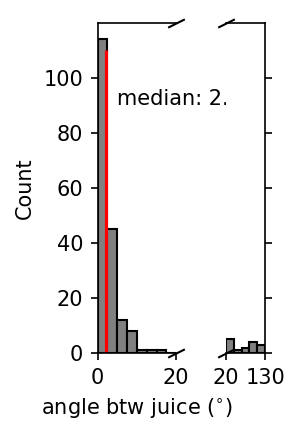

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = csv_order['angle_AB_encoding_tDelay']*180/np.pi

# Create subplots with broken x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(2.1,3), dpi=150,gridspec_kw={'width_ratios': [2, 1]})

# Plot histogram on the first axis (0-20)
ax1.hist(data, bins=8, range=(0, 20), edgecolor='black',color='grey')
ax1.set_xlim(0, 20)  # Set x-axis limits for the first part
median = np.median(csv_order['angle_AB_encoding_tDelay']*180/np.pi)
ax1.vlines(median,0,110,color='r')
ax1.text(5,90,f'median: {median:.1f}')


# Plot histogram on the second axis (20-130)
ax2.hist(data, bins=5, range=(20, 130), edgecolor='black',color='grey')
ax2.set_xlim(20, 130)  # Set x-axis limits for the second part
ax2.set_xticks([20,130])
# Hide the spines between the axes
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the broken axis
d = 0.5  # Size of the diagonal lines
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

# Add labels and title
ax1.set_xlabel('angle btw juice ($^{\circ}$)')
ax1.set_ylabel('Count')
# fig.suptitle('Histogram with Broken X-axis')

# Show the plot
plt.tight_layout()
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/newFig4F.pdf')


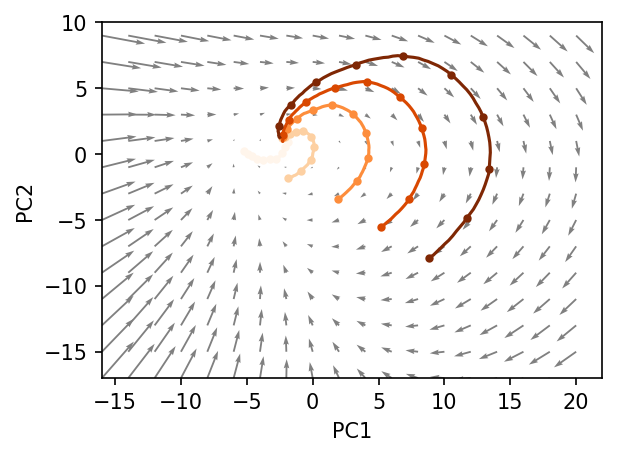

In [ ]:
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')


K,T,N = model_state.shape

pcaObj = PCA(n_components=4)
X = model_state[:,50:250,:].reshape((K*200,N))
pcaObj.fit(X)


t1=50
t2=150
xx,yy=0,1
fig = plt.figure(figsize=(4,3),dpi=150,constrained_layout=True)
ax = fig.add_subplot()

xmin, xmax, ymin, ymax = -16,22,-17,10

uniqueQA = [0,1,2,3,4]
uniqueQB = [0,1,2,3,4,6,8]
Oranges = plt.get_cmap('Oranges',lut=5)
Blues = plt.get_cmap('Blues',lut=8)
for i,qA in enumerate(uniqueQA):
    trace = pcaObj.transform(np.mean(model_state[(qAs==qA)&(seqAB=='AB'),t1:t2+1,:],axis=0))
    traceMarker = trace[np.arange(10,t2-t1+10,10),:]
    ax.plot(trace[:,0],trace[:,1],color=Oranges(i))
    ax.plot(traceMarker[:,0],traceMarker[:,1],marker='.',linestyle='',color=Oranges(i))
    
# for i,qB in enumerate(uniqueQB):
#     trace = pcaObj.transform(np.mean(model_state[(qBs==qB)&(seqAB=='BA'),t1:t2+1,:],axis=0))
#     traceMarker = trace[np.arange(0,t2-t1+10,10),:]
#     ax.plot(trace[:,0],trace[:,1],color=Blues(i))
ax.set_xlabel('PC%d'%(xx+1))
ax.set_ylabel('PC%d'%(yy+1))
ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)


UU = pcaObj.components_[0:2,:]
PP = UU.T @ UU

v1 = pcaObj.components_[0,:]
v2 = pcaObj.components_[1,:]
v0 = pcaObj.mean_

N_grid = 24
xv,yv = np.meshgrid(np.arange(xmin,xmax,2),np.arange(ymin,ymax,2))
state_grid = np.outer(xv.reshape(-1),v1) + np.outer(yv.reshape(-1),v2) +v0

vec_grid_noInput = F(state_grid,np.array([0,0,0,0,0,0,0,0,1]))
vec_grid_noInput_project = vec_grid_noInput @ UU.T
vec_grid_noInput_project = vec_grid_noInput_project.reshape((xv.shape[0],xv.shape[1],2))

xpc = (v1@ UU.T)[0] * xv + (v2@ UU.T)[0] * yv
ypc = (v1@ UU.T)[1] * xv + (v2@ UU.T)[1] * yv
ax.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='projected derivatives',color='grey')

# vec_in_A = W_in[:,0] @ UU.T
# vec_in_B = W_in[:,1] @ UU.T
# ax.quiver(-10,-2.5,vec_in_A[0],vec_in_A[1],label='input direction A',color='orange',scale=5)

# lineModelA = LinearRegression().fit(qAs[seqAB=='AB'].reshape(-1,1),model_state[seqAB=='AB',150,:])
# vec_OfferAxis = lineModelA.coef_[:,0].T @ UU.T
# ax.quiver(-10,-2.5,vec_OfferAxis[0],vec_OfferAxis[1],label='input direction A',color='k',scale=25)

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig5/Fig5E.pdf')

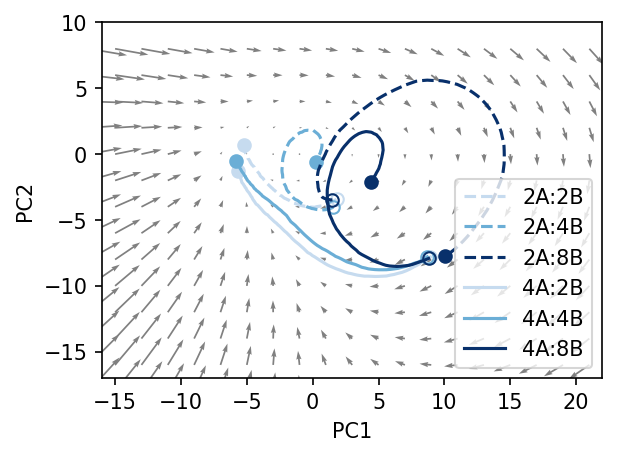

In [9]:
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activityGridPlot.npz')

xx,yy=0,1
fig = plt.figure(figsize=(4,3),dpi=150,constrained_layout=True)
ax = fig.add_subplot()

xmin, xmax, ymin, ymax = -16,22,-17,10

t1,t2=150,250
uniqueQA = [2,4]
uniqueQB = [2,4,8]
Oranges = plt.get_cmap('Oranges',lut=5)
Blues = plt.get_cmap('Blues',lut=9)

for qB in uniqueQB:
    trace = pcaObj.transform(np.mean(model_state[(qBs==qB)&(qAs==uniqueQA[0])&(seqAB=='AB'),t1:t2+1,:],axis=0))
    # traceMarker = trace[np.arange(10,t2-t1+10,10),:]
    ax.plot(trace[:,0],trace[:,1],color=Blues(qB),linestyle='--',label=f'{uniqueQA[0]}A:{qB}B')
    ax.plot(trace[0,0],trace[0,1],color=Blues(qB),marker='o',markerfacecolor='none')    
    ax.plot(trace[-1,0],trace[-1,1],color=Blues(qB),marker='o')

for qB in uniqueQB:
    trace = pcaObj.transform(np.mean(model_state[(qBs==qB)&(qAs==uniqueQA[1])&(seqAB=='AB'),t1:t2+1,:],axis=0))
    # traceMarker = trace[np.arange(10,t2-t1+10,10),:]
    ax.plot(trace[:,0],trace[:,1],color=Blues(qB),label=f'{uniqueQA[1]}A:{qB}B')
    ax.plot(trace[0,0],trace[0,1],color=Blues(qB),marker='o',markerfacecolor='none')    
    ax.plot(trace[-1,0],trace[-1,1],color=Blues(qB),marker='o')

# for i,qB in enumerate(uniqueQB):
#     trace = pcaObj.transform(np.mean(model_state[(qBs==qB)&(seqAB=='BA'),t1:t2+1,:],axis=0))
#     traceMarker = trace[np.arange(0,t2-t1+10,10),:]
#     ax.plot(trace[:,0],trace[:,1],color=Blues(i))
ax.set_xlabel('PC%d'%(xx+1))
ax.set_ylabel('PC%d'%(yy+1))
ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='__projected derivatives',color='grey')
ax.legend()

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig5E_phase2_withLegend.pdf')

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


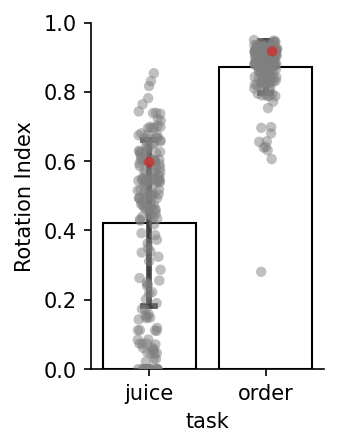

In [42]:
def barStat(csv_juice,csv_order,y_var,ylabel):
    fig,ax = plt.subplots(dpi=150,figsize=(2,3))
    import seaborn as sns
    import pandas as pd
    csv_order['task'] = 'order'
    csv_juice['task'] = 'juice'
    exampleJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
    exampleOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
    csv_order['example'] = False
    csv_juice['example'] = False
    csv_order.loc[csv_order['dirPath']==exampleOrder,'example'] = True
    csv_juice.loc[csv_juice['dirPath']==exampleJuice,'example'] = True
    csv = pd.concat([csv_juice,csv_order])
    csv=csv.sort_values(by=['example'],ascending=True)
    sns.barplot(data=csv,x='task',y=y_var, capsize=.1, errorbar="sd",ax=ax,fill=False,order=['juice','order'])
    sns.stripplot(data=csv,x='task',y=y_var, alpha=.5, hue='example', legend=False,ax=ax,palette={False:'grey',True:'red'},order=['juice','order'])
    ax.set_ylabel(ylabel)
    ax.set_ylim((0,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig

csv_order_rotation = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.rotation.orderTaskDefault.csv',
    header=0)
csv_juice_rotation = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.rotation.juiceTaskDefault.csv',
    header=0)    

fig=barStat(csv_order=csv_order_rotation,csv_juice=csv_juice_rotation,y_var='rotation_axis',ylabel='Rotation Index')
from scipy.stats import ttest_ind
ttest_ind(csv_order_rotation['rotation_axis'],csv_juice_rotation['rotation_axis'])
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/newFig4I.pdf')